In [7]:
%pip install pydicom
%pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/3.3 MB ? eta -:--:--
   ---------------------- ----------------- 1.8/3.3 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 3.3/3.3 MB 12.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
#import pydicom as dicom
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import glob

In [2]:
nii_files = glob.glob("../../Data/Pre-processed/Scaled and padded/**/*.nii", recursive=True)

images = []
for nii_file in nii_files:
    try:
        img_ = nib.load(nii_file).get_fdata()
        images.append(img_)
    except: pass

print(f"{len(images)} scans with shape {images[0].shape}")

59 scans with shape (256, 256, 170)


In [ ]:
#images[0].header.get_zooms() # .get_fdata()

(1.014217, 1.0, 1.2042713)

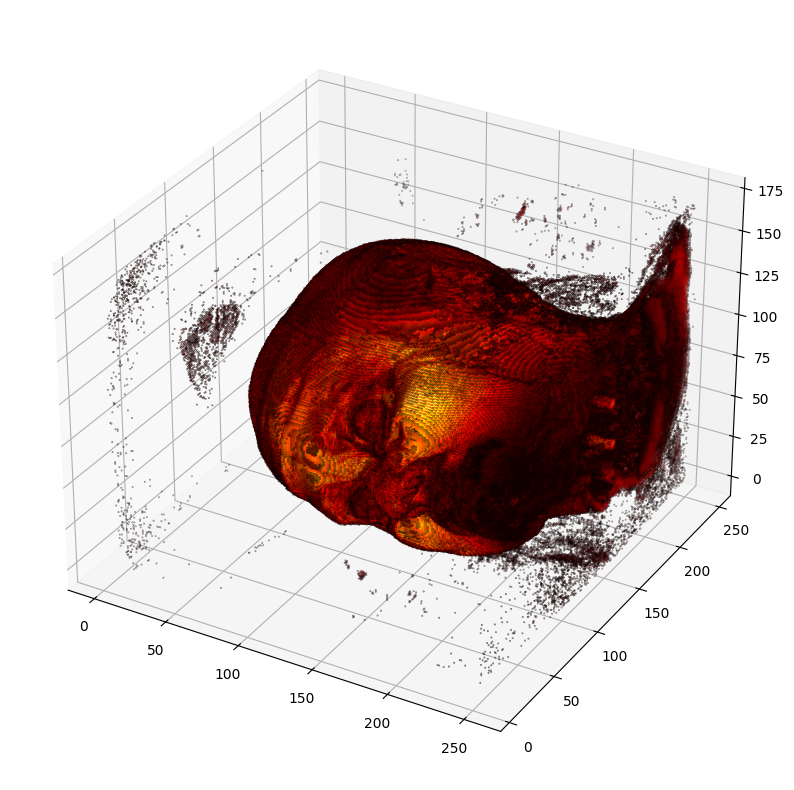

In [ ]:
def plot_image3d(img, threshold = 150):
    indices = np.argwhere(img > threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(indices[:, 0], indices[:, 1], indices[:, 2], c=img[img > threshold], s=0.1)

plot_image3d(images[0])

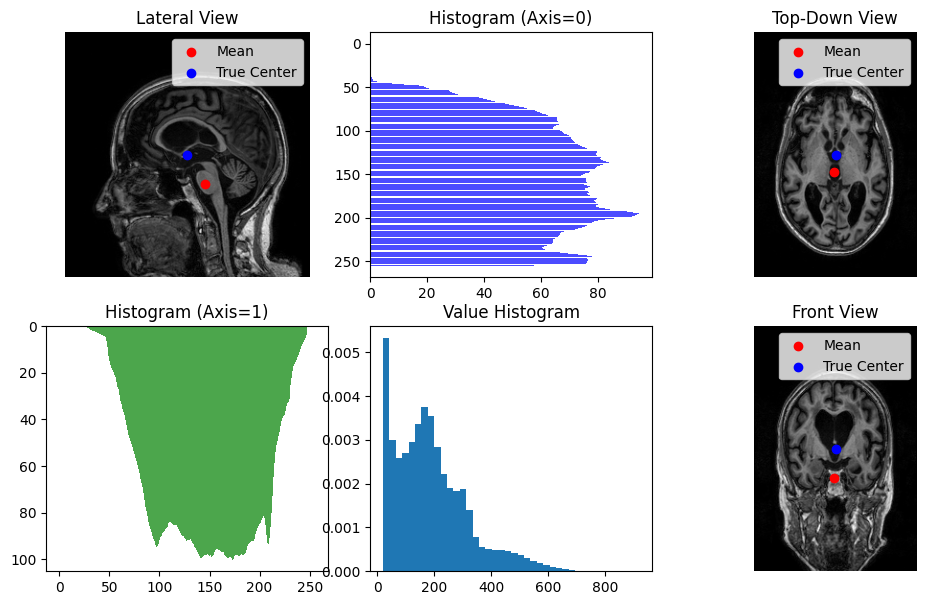

In [4]:
def plot_image(image):
    # Calculate the 3D mean position across the entire brain scan
    total_mass = np.sum(image)
    x_mean = np.sum(np.sum(np.sum(image, axis=2), axis=1) * np.arange(image.shape[0])) / total_mass
    y_mean = np.sum(np.sum(np.sum(image, axis=2), axis=0) * np.arange(image.shape[1])) / total_mass
    z_mean = np.sum(np.sum(np.sum(image, axis=0), axis=0) * np.arange(image.shape[2])) / total_mass
    
    # Calculate the true center of the image
    x_center = image.shape[0] / 2
    y_center = image.shape[1] / 2
    z_center = image.shape[2] / 2
    
    fig = plt.figure(figsize=(12, 7))
    grid = plt.GridSpec(2, 3, wspace=0.15, hspace=0.2)

    # Lateral view
    ax1 = fig.add_subplot(grid[0, 0])
    ax1.imshow(image[:, :, int(z_center)], cmap='gray')
    ax1.set_title("Lateral View")
    ax1.scatter([y_mean], [x_mean], color='red', label="Mean")
    ax1.scatter([y_center], [x_center], color='blue', label="True Center")
    ax1.legend()
    ax1.axis('off')

    # Histogram (Axis=0)
    data_axis_0 = image.mean(axis=(1, 2))
    ax2 = fig.add_subplot(grid[0, 1])
    ax2.barh(range(len(data_axis_0)), data_axis_0, color='blue', alpha=0.7)
    ax2.set_title("Histogram (Axis=0)")
    ax2.invert_yaxis()

    # Histogram (Axis=1)
    data_axis_1 = image.mean(axis=(0, 2))
    ax3 = fig.add_subplot(grid[1, 0])
    ax3.bar(range(len(data_axis_1)), data_axis_1, color='green', alpha=0.7)
    ax3.set_title("Histogram (Axis=1)")
    ax3.invert_yaxis()

    # Value histogram
    ax4 = fig.add_subplot(grid[1, 1])
    ax4.hist(image[image > 20].reshape(-1), bins=40,density=True)
    ax4.set_title("Value Histogram")

    # Top-Down view
    ax5 = fig.add_subplot(grid[0, 2])
    top_down_slice = image[int(x_center), :, :]
    ax5.imshow(top_down_slice, cmap='gray')
    ax5.set_title("Top-Down View")
    ax5.scatter([z_mean], [y_mean], color='red', label="Mean")
    ax5.scatter([z_center], [y_center], color='blue', label="True Center")
    ax5.legend()
    ax5.axis('off')

    # Front view
    ax6 = fig.add_subplot(grid[1, 2])
    front_slice = image[:, int(y_center), :]
    ax6.imshow(front_slice, cmap='gray')
    ax6.set_title("Front View")
    ax6.scatter([z_mean], [x_mean], color='red', label="Mean")
    ax6.scatter([z_center], [x_center], color='blue', label="True Center")
    ax6.legend()
    ax6.axis('off')

plot_image(images[30])

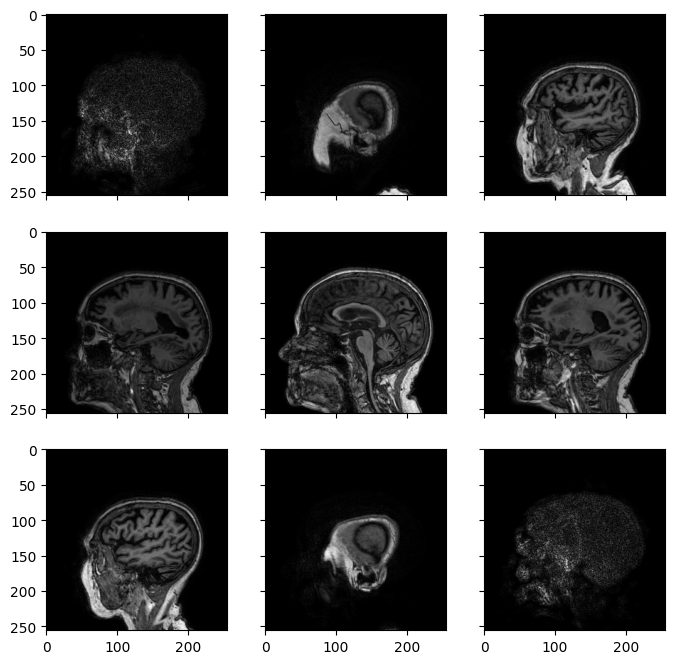

In [5]:
def plot_image_slices(image):
    _, axes = plt.subplots(3,3, figsize=(8,8),sharex=True,sharey=True)
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(image[:,:,int((i+0.5)*image.shape[2]/9)], cmap='gray')

plot_image_slices(images[12])

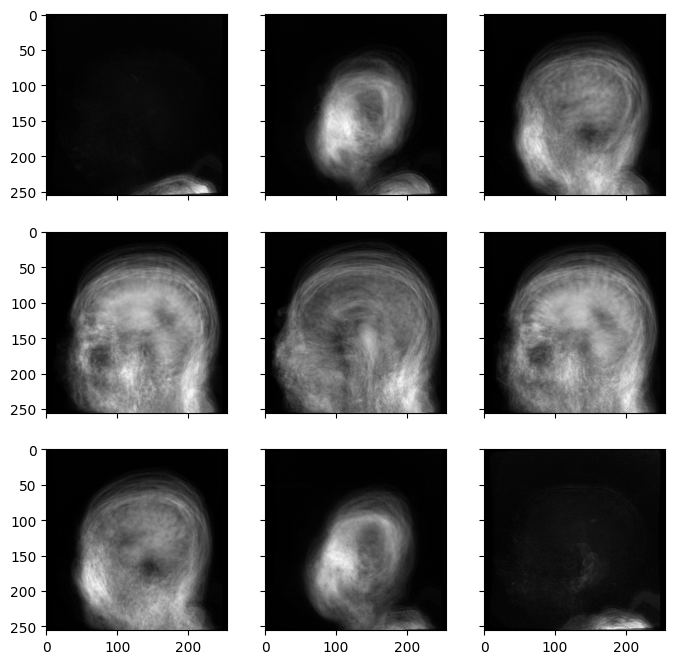

In [7]:
plot_image_slices(np.mean(images,axis=0))

8 247 1 169
86.21491019641374 128.89480159214935


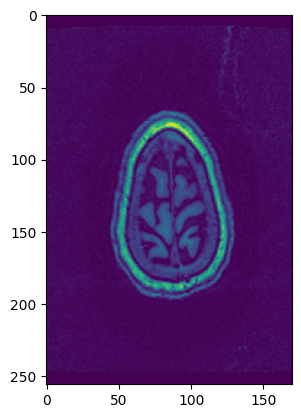

In [8]:
# Adjust brain position
# Locate centerpoint in XZ
image = images[0]
slice = image[60,:,:]
plt.imshow(image[60,:,:])
for zmin in range(0, slice.shape[0]):
    if any(slice[zmin,:] > 50): break
for zmax in range(slice.shape[0]-1,0,-1):
    if any(slice[zmax,:] > 50): break
for xmin in range(0, slice.shape[1]):
    if any(slice[:,xmin] > 50): break
for xmax in range(slice.shape[1]-1,0,-1):
    if any(slice[:,xmax] > 50): break
print(zmin,zmax,xmin,xmax)

x=np.arange(slice.shape[1])
z=np.arange(slice.shape[0])
xbar=np.sum(x*slice)/np.sum(slice)
zbar=np.sum(z*slice.T)/np.sum(slice)
print(xbar,zbar)

Some images are rotated. To check if they are rotated, we can see along which edge the brightness is highest. If the neck is oriented downwards, the bottom edge is (should be) brightest. Otherwise, rotate the image about the diagonal and flip the dimensions back.

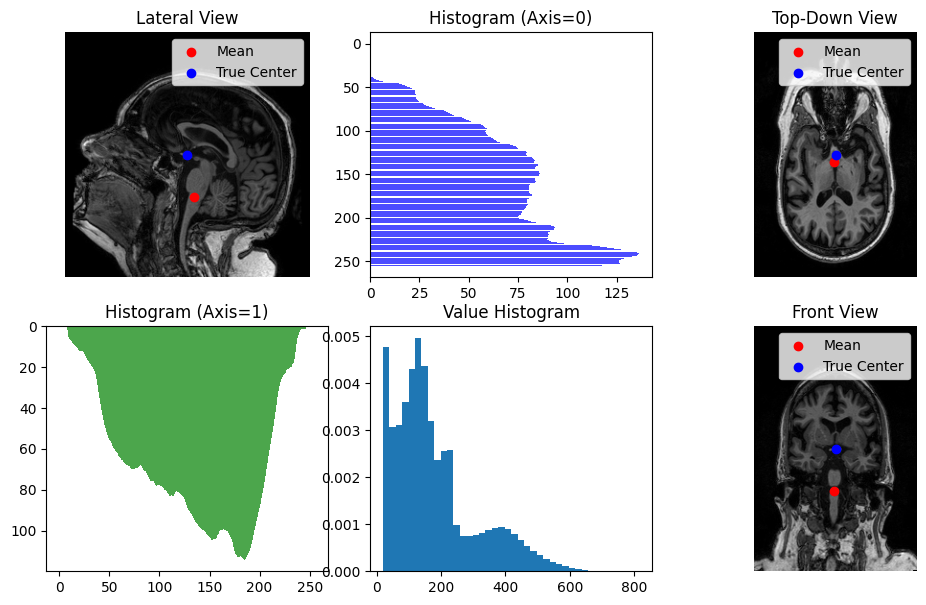

In [164]:
def check_and_correct_rotation(img):
    bottom_edge_brightness = np.mean(img[-1, :, :])
    right_edge_brightness = np.mean(img[:, -1, :])
    # Bottom edge SHOULD have more brightness
    if right_edge_brightness > bottom_edge_brightness:
        img = np.transpose(img, axes=(1, 0, 2))  # Swap x and y axes
        img = img[:, :, ::-1]  # Reverse the swapped axis
    return img

plot_image(check_and_correct_rotation(images[77]))

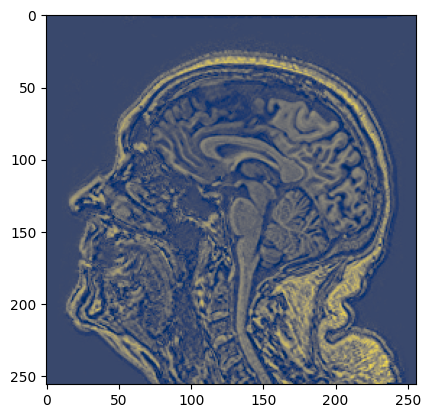

In [168]:
def edge_detection(image):
    edge_x = np.clip(image-np.roll(image,3,axis=0),-100,100)
    edge_y = np.clip(image-np.roll(image,3,axis=1),-100,100)
    edge_z = np.clip(image-np.roll(image,3,axis=2),-100,100)
    return image + (edge_x + edge_y + edge_z)

plt.imshow(edge_detection(images[70])[:,:,85], cmap='cividis')

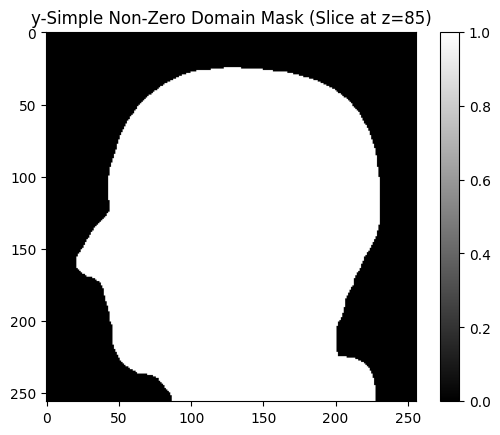

Mesh saved as output_mesh.stl


In [ ]:
from scipy.ndimage import uniform_filter
from skimage.measure import marching_cubes
from stl import mesh

image = uniform_filter(images[3], size=10)
mask = np.zeros_like(image, dtype=np.uint8)

# Find the non-zero j indices for all ik coordinates as mask
for x in range(image.shape[0]):
    for z in range(image.shape[2]):
        y_indices = np.where(image[x, :, z] > 40)[0]
        if y_indices.size > 4:
            y_start, y_end = y_indices[2], y_indices[-2]
            mask[x, y_start:y_end + 1, z] = 1

# Visualize the result for a slice
plt.imshow(mask[:, :, 85], cmap='gray')
plt.title("y-Simple Non-Zero Domain Mask (Slice at z=85)")

# Generate a mesh using marching cubes and save output as STL
verts, faces, normals, values = marching_cubes(mask, level=0.5)
output_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        output_mesh.vectors[i][j] = verts[f[j], :]

output_mesh.save("output_mesh.stl")
print("Mesh saved as output_mesh.stl")

In [ ]:
# https://arxiv.org/pdf/2204.05778
# used adam with lr=1e-3, batch_size=32
print(0.97*(1-0.285) / (0.03*(1-0.778))) # thresh loss remove sample = 1.3*mean loss of this epoch (each 5th epoch)
print(0.97*(1-0.175) / (0.03*(1-0.500))) # signal to noise ratio keeps going down after this...
print(0.97*(1-0.093) / (0.03*(1-0.508)))

104.13663663663667
53.349999999999994
59.60636856368564
49.47899618112385


Downsampled shape: (51, 51, 34)
Optimizing alignment for scan 1/25...
Optimizing alignment for scan 2/25...
Optimizing alignment for scan 3/25...
Optimizing alignment for scan 5/25...
Optimizing alignment for scan 6/25...
Optimizing alignment for scan 7/25...
Optimizing alignment for scan 8/25...
Optimizing alignment for scan 9/25...
Optimizing alignment for scan 10/25...
Optimizing alignment for scan 11/25...
Optimizing alignment for scan 12/25...
Optimizing alignment for scan 13/25...
Optimizing alignment for scan 14/25...
Optimizing alignment for scan 15/25...
Optimizing alignment for scan 16/25...
Optimizing alignment for scan 17/25...
Optimizing alignment for scan 18/25...
Optimizing alignment for scan 19/25...
Optimizing alignment for scan 20/25...
Optimizing alignment for scan 21/25...
Optimizing alignment for scan 22/25...
Optimizing alignment for scan 23/25...
Optimizing alignment for scan 24/25...
Optimizing alignment for scan 25/25...
Applying transformation to full-resoluti

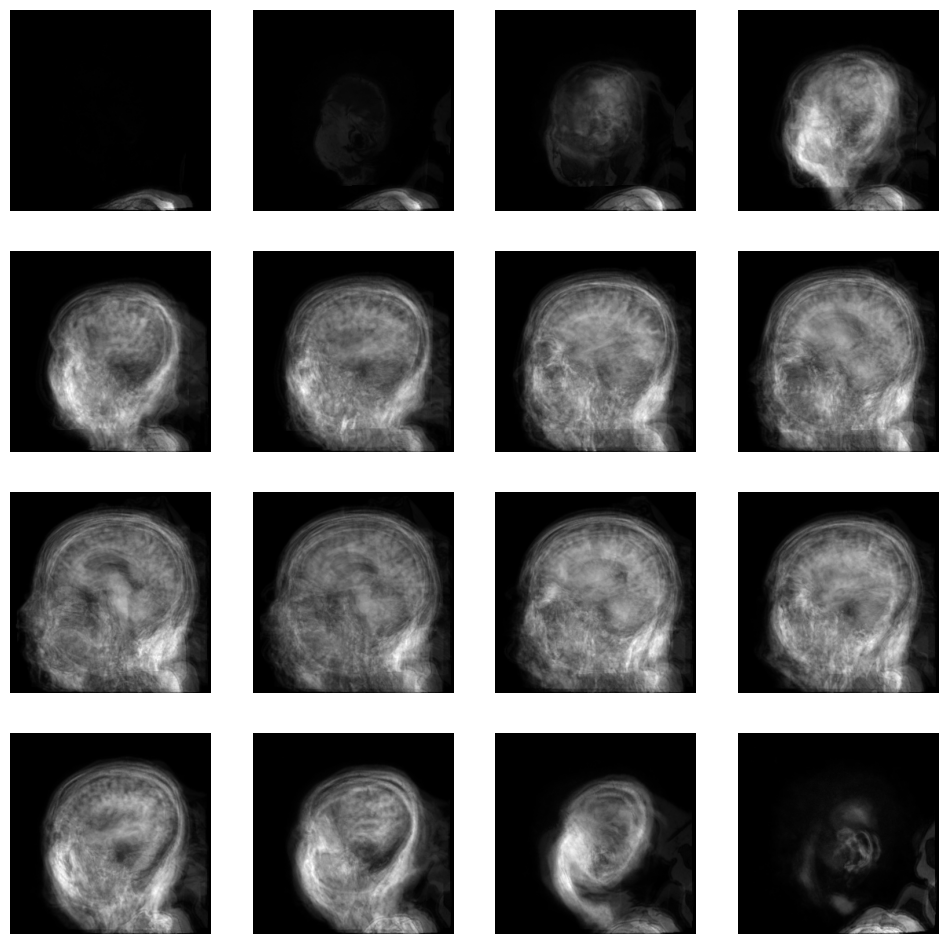

In [293]:
import scipy.optimize
from scipy.ndimage import affine_transform, zoom

# Parameters
downsample_factor = 0.2  # Adjust as needed for faster processing
reference_index = 3

# Downsample images
def downsample(img, factor):
    return zoom(img, factor, order=1)  # Linear interpolation for downsampling

def check_and_correct_rotation(img):
    """
    Check the brightness along edges and rotate the image if necessary.
    :param img: 3D numpy array (image data)
    :return: Corrected image
    """
    # Calculate mean brightness along edges
    bottom_edge_brightness = np.mean(img[-1, :, :])  # Bottom edge along z-axis
    right_edge_brightness = np.mean(img[:, -1, :])  # Right edge along y-axis
    
    # Determine if rotation is needed
    if right_edge_brightness > bottom_edge_brightness:
        #print("Rotating image 180 degrees about the xy-diagonal.")
        # Rotate about the xy-diagonal
        img = np.transpose(img, axes=(1, 0, 2))  # Swap x and y axes
        img = img[:, :, ::-1]  # Reverse the swapped axis
    return img

# Apply rotation correction to all images
corrected_images = []
for i, img in enumerate(images):
    #print(f"Checking and correcting rotation for image {i+1}/{len(images)}...")
    corrected_img = check_and_correct_rotation(img)
    corrected_images.append(corrected_img)

# Downsample corrected images for alignment
downsampled_images = [downsample(edge_detection(img), downsample_factor) for img in corrected_images]

print(f"Downsampled shape: {downsampled_images[0].shape}")

# Reference scan (downsampled)
reference_scan = downsampled_images[reference_index]

# Transformation function
def transform_image(img, params, full_shape=None):
    tx, ty, tz, rx, ry, rz, scale = params
    Rx = np.array([[1, 0, 0], [0, np.cos(rx), -np.sin(rx)], [0, np.sin(rx), np.cos(rx)]])
    Ry = np.array([[np.cos(ry), 0, np.sin(ry)], [0, 1, 0], [-np.sin(ry), 0, np.cos(ry)]])
    Rz = np.array([[np.cos(rz), -np.sin(rz), 0], [np.sin(rz), np.cos(rz), 0], [0, 0, 1]])
    R = Rx @ Ry @ Rz
    scaling_matrix = np.eye(3) * scale
    transformation_matrix = R @ scaling_matrix
    transformed_img = affine_transform(img, transformation_matrix, offset=(tx, ty, tz), order=1)
    if full_shape:
        transformed_img = zoom(transformed_img, [fs / ds for fs, ds in zip(full_shape, img.shape)], order=1)
    return transformed_img

# Loss function
def loss_function(params, moving_img, reference_img):
    transformed_img = transform_image(moving_img, params)
    return np.mean((transformed_img - reference_img)**2) #  Should maybe use edge detection instead?!

# Optimize alignment
aligned_images_downsampled = []
transform_params = []

for i, img in enumerate(downsampled_images):
    if i == reference_index:  # Skip reference
        aligned_images_downsampled.append(img)
        transform_params.append(None)  # No transformation for reference
        continue
    
    print(f"Optimizing alignment for scan {i+1}/{len(images)}...")
    initial_params = [0, 0, 0, 0, 0, 0, 1]  # Initial guess
    result = scipy.optimize.minimize(
        loss_function, 
        initial_params, 
        args=(img, reference_scan), 
        method='Powell'
    )
    optimal_params = result.x
    transform_params.append(optimal_params)
    aligned_img = transform_image(img, optimal_params)
    aligned_images_downsampled.append(aligned_img)

# Apply transformations to full-resolution images
aligned_images_full = []
for i, img in enumerate(images):
    if i == reference_index:  # Skip reference
        aligned_images_full.append(img)
        continue
    print(f"Applying transformation to full-resolution scan {i+1}/{len(images)}...")
    aligned_img = transform_image(img, transform_params[i], full_shape=img.shape)
    aligned_images_full.append(aligned_img)

# Calculate the mean brain
mean_brain = np.mean(aligned_images_full, axis=0)

# Visualize the mean brain
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.reshape(-1)):
    slice_index = i * int(mean_brain.shape[2] / 16)
    ax.imshow(mean_brain[:, :, slice_index], cmap='gray')
    ax.axis('off')

plt.show()


Downsampled shape: (51, 51, 34)
Optimizing alignment for scan 1/25...
Optimizing alignment for scan 2/25...
Optimizing alignment for scan 3/25...
Optimizing alignment for scan 5/25...
Optimizing alignment for scan 6/25...
Optimizing alignment for scan 7/25...
Optimizing alignment for scan 8/25...
Optimizing alignment for scan 9/25...
Optimizing alignment for scan 10/25...
Optimizing alignment for scan 11/25...
Optimizing alignment for scan 12/25...
Optimizing alignment for scan 13/25...
Optimizing alignment for scan 14/25...
Optimizing alignment for scan 15/25...
Optimizing alignment for scan 16/25...
Optimizing alignment for scan 17/25...
Optimizing alignment for scan 18/25...
Optimizing alignment for scan 19/25...
Optimizing alignment for scan 20/25...
Optimizing alignment for scan 21/25...
Optimizing alignment for scan 22/25...
Optimizing alignment for scan 23/25...
Optimizing alignment for scan 24/25...
Optimizing alignment for scan 25/25...
Applying transformation to full-resoluti

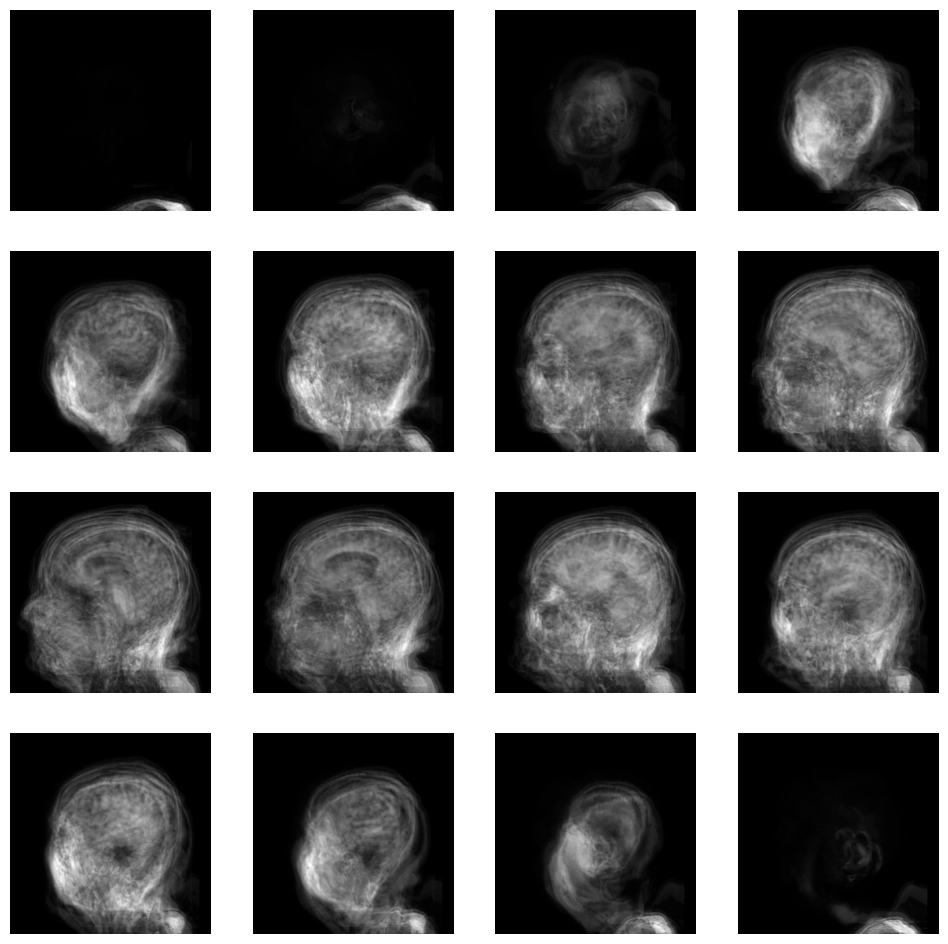

In [124]:
import scipy.optimize
from scipy.ndimage import affine_transform, zoom

# Parameters
downsample_factor = 0.2  # Adjust as needed for faster processing
reference_index = 3

# Downsample images
def downsample(img, factor):
    return zoom(img, factor, order=1)  # Linear interpolation for downsampling

downsampled_images = [downsample(img, downsample_factor) for img in images]
print(f"Downsampled shape: {downsampled_images[0].shape}")

# Reference scan (downsampled)
reference_scan = downsampled_images[reference_index]

# Transformation function
def transform_image(img, params, full_shape=None):
    tx, ty, tz, rx, ry, rz, scale = params
    Rx = np.array([[1, 0, 0], [0, np.cos(rx), -np.sin(rx)], [0, np.sin(rx), np.cos(rx)]])
    Ry = np.array([[np.cos(ry), 0, np.sin(ry)], [0, 1, 0], [-np.sin(ry), 0, np.cos(ry)]])
    Rz = np.array([[np.cos(rz), -np.sin(rz), 0], [np.sin(rz), np.cos(rz), 0], [0, 0, 1]])
    R = Rx @ Ry @ Rz
    scaling_matrix = np.eye(3) * scale
    transformation_matrix = R @ scaling_matrix
    transformed_img = affine_transform(img, transformation_matrix, offset=(tx, ty, tz), order=1)
    if full_shape:
        transformed_img = zoom(transformed_img, [fs / ds for fs, ds in zip(full_shape, img.shape)], order=1)
    return transformed_img

# Loss function
def loss_function(params, moving_img, reference_img):
    transformed_img = transform_image(moving_img, params)
    return np.mean((transformed_img[:,:,::5] - reference_img[:,:,::5])**2)

# Optimize alignment
aligned_images_downsampled = []
transform_params = []

for i, img in enumerate(downsampled_images):
    if i == reference_index:  # Skip reference
        aligned_images_downsampled.append(img)
        transform_params.append(None)  # No transformation for reference
        continue
    
    print(f"Optimizing alignment for scan {i+1}/{len(images)}...")
    initial_params = [0, 0, 0, 0, 0, 0, 1]  # Initial guess
    result = scipy.optimize.minimize(
        loss_function, 
        initial_params, 
        args=(img, reference_scan), 
        method='Powell'
    )
    optimal_params = result.x
    transform_params.append(optimal_params)
    aligned_img = transform_image(img, optimal_params)
    aligned_images_downsampled.append(aligned_img)

# Apply transformations to full-resolution images
aligned_images_full = []
for i, img in enumerate(images):
    if i == reference_index:  # Skip reference
        aligned_images_full.append(img)
        continue
    print(f"Applying transformation to full-resolution scan {i+1}/{len(images)}...")
    aligned_img = transform_image(img, transform_params[i], full_shape=img.shape)
    aligned_images_full.append(aligned_img)

# Calculate the mean brain
mean_brain = np.mean(aligned_images_full, axis=0)

# Visualize the mean brain
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.reshape(-1)):
    slice_index = i * int(mean_brain.shape[2] / 16)
    ax.imshow(mean_brain[:, :, slice_index], cmap='gray')
    ax.axis('off')

plt.show()